# Sentiment Prediction in Dialogue with Graph Neural Networks

### This notebook implements a Graph Neural Network (GNN) for predicting the sentiment of utterances in dialogue. The model uses utterance features, builds graphs representing dialogues, and trains a GNN to classify the sentiment of each utterance.

# 1. Installing Packages

In [1]:
!pip install transformers
!pip install dask
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.4 MB/s eta 0:00:00


# 2. Data Loading and Preparation

In [ ]:
import pandas as pd

# Load train, validation, and test data, selecting relevant columns
df_train = pd.read_csv("./drive/MyDrive/train_sent_emo.csv")[["Utterance","Emotion","Sentiment","Dialogue_ID","Utterance_ID"]]
df_val = pd.read_csv("./drive/MyDrive/dev_sent_emo.csv")[["Utterance","Emotion","Sentiment","Dialogue_ID","Utterance_ID"]]
df_test = pd.read_csv("./drive/MyDrive/test_sent_emo.csv")[["Utterance","Emotion","Sentiment","Dialogue_ID","Utterance_ID"]]

# concatenate the data into one DataFrame
df = pd.concat([df_train, df_val, df_test], axis=0)
df = df.reset_index(drop=True)

# Define index positions for validation and test sets
val_start = df_train.shape[0]
test_start = val_start + df_val.shape[0]

# Adjust Dialogue_ID after the combination
df.iloc[val_start:test_start,3] = df.iloc[val_start:test_start,3] + (df.iloc[val_start-1,3] + 1)
df.iloc[test_start:,3] = df.iloc[test_start:,3] + (df.iloc[test_start-1,3] + 1)

In [ ]:
df

,Utterance,Emotion,Sentiment,Dialogue_ID,Utterance_ID
0,also I was the point person on my company’s tr...,neutral,neutral,0,0
1,You must’ve had your hands full.,neutral,neutral,0,1
2,That I did. That I did.,neutral,neutral,0,2
3,So let’s talk a little bit about your duties.,neutral,neutral,0,3
4,My duties? All right.,surprise,positive,0,4
...,...,...,...,...,...
13703,"Yeah, I mean, come on Ross, no one will even n...",neutral,neutral,1432,11
13704,They’re not listening too me?,surprise,negative,1432,12
13705,Of course they’re listening to you! Everybody ...,neutral,neutral,1432,13
13706,Monica you really think I should try this phas...,neutral,neutral,1432,14


# 3. Grouping Utterances by Dialogue
### Group all utterances by `Dialogue_ID` to prepare the data for graph construction.


In [ ]:
def groupDialogue(df):
    """Group all utterances and their emotions and sentiments by `Dialogue_ID`."""
    dialogues = []
    emotions = []
    sentiment = []
    for _, group in df.groupby('Dialogue_ID'):
        # Define or initialize variable
        group = group.sort_values(by="Utterance_ID")
        dialogues.append(list(group["Utterance"]))
        emotions.append(list(group["Emotion"]))
        sentiment.append(list(group["Sentiment"]))
    return dialogues, emotions, sentiment

In [ ]:
# Group the dialogues
X, y, sentiments = groupDialogue(df)

# 4. Data preprocessing: Utterance Feature Vectors Creation
### Extract feature vectors for each utterance using a pre-trained transformer model.


In [ ]:
from transformers import AutoTokenizer, AutoModel

# Import the emberta-base model for text vectorization
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-base")
model = AutoModel.from_pretrained("tae898/emoberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

def getUtteranceVec(utterance,ind = 1):
    """Encodes an utterance and returns the specified layer's output."""
    input_ids = tokenizer.encode(utterance, add_special_tokens=True)
    outputs = model(torch.tensor([input_ids]))
    feature_vec = outputs[ind].detach().numpy()[0]

    return feature_vec

In [ ]:
from tqdm import tqdm
import dask

def getFeaturesVec(dialogues):
  """Extract features for all utterances in each dialogue."""
  features_vecs = []
  for dialogue in tqdm(dialogues):
    dialogue_vecs = []
    for utterance in dialogue:
      utterance_vec = getUtteranceVec(utterance)
      dialogue_vecs.append(utterance_vec)
    features_vecs.append(dialogue_vecs)

  return features_vecs


In [ ]:
X_vecs = getFeaturesVec(X)

### Save processed data

In [ ]:
# import numpy as np
# np.save("X_vecs.npy",np.array(X_vecs,dtype=object))

In [ ]:
# Import the processed data
import numpy as np

X_vecs = np.load("drive/MyDrive/X_vecs.npy", allow_pickle = True)

# 6. Define Emotion and Sentiment Labels

### Set the labels for emotions and sentiments to be used in graph construction and evaluation.


In [ ]:
# Define unique emotion labels
labels = list(df["Emotion"].unique())
labels.sort()
labels

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

In [ ]:
# Define order of sentiments
sentiments_labels = ['negative','neutral','positive']
sentiments_labels

['negative', 'neutral', 'positive']

# 7. Graph Construction for Dialogues
### Create edge indices and feature vectors for graph-based dialogue representation.


In [ ]:
from torch_geometric.data import Data
import torch
import numpy as np
from torch_geometric.utils import add_self_loops

def dialogueEdgeIndex(n, start_ind, fully_connected):
  """
    Generates edge indices for a dialogue graph.

    n: The total number of nodes in the graph.
    start_ind: The starting index for node numbering.

    Returns: A NumPy array of shape (2, num_edges) containing the edge indices.
  """
  n += start_ind
  line0, line1 = [],[]

  if fully_connected:
    for i in range(start_ind,n-1):
      for j in range(i+1,n):
        line0.extend([i,j])
        line1.extend([j,i])
  else:
    for i in range(start_ind,n-1):
      line0.extend([i,i+1])
      line1.extend([i+1,i])

  return np.array([line0, line1])

def createEdgeIndex(X, dialogue_fully_connected):
  """
    Creates edge indices for a dialogue graph.

    X: A list of dialogues.

    Returns: A PyTorch tensor representing the edge indices.
  """
  edge_index = [[],[]]
  current_ind = 0
  for dialogue in X:
    sub_edge_index = dialogueEdgeIndex(len(dialogue),current_ind,dialogue_fully_connected)
    edge_index[0].extend(sub_edge_index[0])
    edge_index[1].extend(sub_edge_index[1])
    current_ind += len(dialogue)


  edge_index = torch.tensor(edge_index, dtype=torch.long)

  edge_index = add_self_loops(edge_index)[0]
  return edge_index

def getEdgeWeights(sentiments,fully_connected):
  """
    Calculates edge weights based on sentiment shifts.

    Returns: A tuple of two lists: edge weights and self-loop weights.
  """
  sentiment_shifts = []
  for i in range(len(sentiments)-1):
    max_bound = len(sentiments) if fully_connected else i+2
    for j in range(i+1,max_bound):
      if sentiments[i] == sentiments[j]:
        sentiment_shifts.extend([1,1])
      else: sentiment_shifts.extend([-1,-1])
  return (sentiment_shifts, [1 for _ in range(len(sentiments))])

def getEdgeFeatures(sentiments,fully_connected):
  """
    Calculates edge features based on sentiment labels.

    Returns: A tuple of two lists: edge features and self-loop features.
  """
  if fully_connected:
    edge_features = []
    for i in range(len(sentiments)-1):
      for j in range(i+1,len(sentiments)):
        current_sen_ind = sentiments_labels.index(sentiments[i])
        next_sen_ind = sentiments_labels.index(sentiments[j])
        edge_features.extend([[current_sen_ind,next_sen_ind] for _ in range(2)])


  else:
    edge_features = []
    for i in range(len(sentiments)-1):
      current_sen_ind = sentiments_labels.index(sentiments[i])
      next_sen_ind = sentiments_labels.index(sentiments[i+1])
      edge_features.extend([[current_sen_ind,next_sen_ind] for _ in range(2)])

  return (edge_features, [[sentiments_labels.index(sent) for _ in range(2)] for sent in sentiments])

def labelsEncoding(y):
  """
    Encodes sentiment labels into numerical indices.
  """
  return [labels.index(emo) for emo in y]


In [ ]:

def createGraph(X,y,type, dialogue_fully_connected, sentiment_shift):
  """
    Creates a PyTorch Geometric Data object representing the graph.

    X: A list of dialogues.
    y: A list of sentiment labels for each dialogue.
    sentiment_shift: A boolean indicating whether to use sentiment shifts as edge features.

    Returns: A PyTorch Geometric Data object.
  """
  edge_index = createEdgeIndex(X,dialogue_fully_connected)

  if sentiment_shift:
    if type=="GCN":
      edge_weights = [x for dialogue_sentiments in sentiments for x in getEdgeWeights(dialogue_sentiments, dialogue_fully_connected)[0]]
      edge_weights.extend([x for dialogue_sentiments in sentiments for x in getEdgeWeights(dialogue_sentiments, dialogue_fully_connected)[1]])
      edge_attr = torch.tensor(edge_weights, dtype=torch.float)
    elif type=="GAT":
      edge_weights = [x for dialogue_sentiments in sentiments for x in getEdgeFeatures(dialogue_sentiments,dialogue_fully_connected)[0]]
      edge_weights.extend([x for dialogue_sentiments in sentiments for x in getEdgeFeatures(dialogue_sentiments,dialogue_fully_connected)[1]])
      edge_attr = torch.tensor(edge_weights, dtype=torch.float)

  nodes_features = [feature_vec for dialogue in X for feature_vec in dialogue]
  x = torch.tensor(nodes_features)

  y_flattend = [emo for dialogue in y for emo in dialogue]

  y_encoded = labelsEncoding(y_flattend)
  y_encoded = torch.tensor(y_encoded, dtype=torch.long)


  data = Data(x=x, edge_index=edge_index, y=y_encoded)

  data.train_mask = range(val_start)
  data.val_mask = range(val_start, test_start)
  data.test_mask = range(test_start, len(y_flattend))

  if sentiment_shift:
    data.edge_attr = edge_attr

  return data


# 8. Define and Train the Graph Neural Network Model
### Define a GNN model architecture and training functions for sentiment classification.


In [ ]:
torch.manual_seed(42)

## GCN Model definition

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs, verbose = True, early_stopping=False ,patience=None, keep_best_model = False, monitor='val_loss'):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=1e-4)

        if early_stopping:
          if not patience: raise ValueError("'patience' must be set when 'early_stopping' is True.")
          counter = 0
          min_val_loss = float("inf")
          best_model_state = self.state_dict()

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            if verbose:
              if(epoch % 20 == 0):
                  val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                    data.y[data.val_mask])
                  print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                        f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                        f'Val Acc: {val_acc*100:.2f}%')


            if early_stopping:
              if (val_loss <= min_val_loss):
                min_val_loss = val_loss
                if keep_best_model: best_model_state = self.state_dict()
                counter = 0
              else:
                counter += 1
                if (counter >= patience):
                  if verbose: print('Early stopping!')
                  if (keep_best_model):
                    self.load_state_dict(best_model_state)
                    if verbose: print("taking the best model")
                  break


    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [ ]:
def trainGCN(data, verbose = True):

  num_features = len(X_vecs[0][0])
  num_classes = len(labels)
  gcn_model = GCN(num_features, 16, num_classes)
  gcn_model.fit(data, epochs=500,verbose = verbose, early_stopping = True, patience=60,keep_best_model=True)

  acc = gcn_model.test(data)
  print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

  return gcn_model

## LineConGCN ss (Line connected graph convolution network with sentiment shift)

In [ ]:
data = createGraph(X_vecs,y,type="GCN",dialogue_fully_connected=False,sentiment_shift=True)

gcn_lcon_ss = trainGCN(data, verbose=True)


Epoch   0 | Train Loss: 2.128 | Train Acc:  5.09% | Val Loss: 2.10 | Val Acc: 5.50%
Epoch  20 | Train Loss: 1.218 | Train Acc: 57.71% | Val Loss: 1.24 | Val Acc: 55.46%
Epoch  40 | Train Loss: 1.045 | Train Acc: 64.79% | Val Loss: 1.02 | Val Acc: 63.57%
Epoch  60 | Train Loss: 0.987 | Train Acc: 65.32% | Val Loss: 0.97 | Val Acc: 64.83%
Epoch  80 | Train Loss: 0.955 | Train Acc: 66.07% | Val Loss: 0.93 | Val Acc: 65.92%
Epoch 100 | Train Loss: 0.935 | Train Acc: 66.67% | Val Loss: 0.91 | Val Acc: 65.92%
Epoch 120 | Train Loss: 0.920 | Train Acc: 67.02% | Val Loss: 0.90 | Val Acc: 65.83%
Epoch 140 | Train Loss: 0.907 | Train Acc: 67.39% | Val Loss: 0.89 | Val Acc: 65.92%
Epoch 160 | Train Loss: 0.897 | Train Acc: 67.66% | Val Loss: 0.89 | Val Acc: 66.19%
Epoch 180 | Train Loss: 0.889 | Train Acc: 67.88% | Val Loss: 0.89 | Val Acc: 66.10%
Epoch 200 | Train Loss: 0.882 | Train Acc: 68.11% | Val Loss: 0.89 | Val Acc: 65.92%
Epoch 220 | Train Loss: 0.875 | Train Acc: 68.23% | Val Loss: 0.89

## LineConGCN (Line Connected Graph Convolution Network)

In [ ]:
data = createGraph(X_vecs,y,type="GCN",dialogue_fully_connected=False,sentiment_shift=False)
gcn_lcon = trainGCN(data, verbose=False)


GCN test accuracy: 68.28%



## FullConGCN ss (Fully Connected Graph Convolution Network with sentiment shift)

In [ ]:
data = createGraph(X_vecs,y,type="GCN",dialogue_fully_connected=True,sentiment_shift=True)
gcn_fcon_ss = trainGCN(data)

Epoch   0 | Train Loss: 1.921 | Train Acc: 20.80% | Val Loss: 1.94 | Val Acc: 17.85%
Epoch  20 | Train Loss: 1.384 | Train Acc: 49.44% | Val Loss: 1.44 | Val Acc: 44.00%
Epoch  40 | Train Loss: 1.336 | Train Acc: 50.65% | Val Loss: 1.37 | Val Acc: 44.82%
Epoch  60 | Train Loss: 1.319 | Train Acc: 51.51% | Val Loss: 1.35 | Val Acc: 47.25%
Epoch  80 | Train Loss: 1.309 | Train Acc: 51.63% | Val Loss: 1.34 | Val Acc: 47.34%
Epoch 100 | Train Loss: 1.301 | Train Acc: 51.73% | Val Loss: 1.34 | Val Acc: 47.34%
Epoch 120 | Train Loss: 1.295 | Train Acc: 51.79% | Val Loss: 1.33 | Val Acc: 48.06%
Epoch 140 | Train Loss: 1.290 | Train Acc: 51.92% | Val Loss: 1.33 | Val Acc: 48.33%
Epoch 160 | Train Loss: 1.285 | Train Acc: 51.94% | Val Loss: 1.33 | Val Acc: 48.15%
Epoch 180 | Train Loss: 1.281 | Train Acc: 52.05% | Val Loss: 1.32 | Val Acc: 48.06%
Epoch 200 | Train Loss: 1.277 | Train Acc: 52.07% | Val Loss: 1.32 | Val Acc: 48.33%
Epoch 220 | Train Loss: 1.273 | Train Acc: 52.27% | Val Loss: 1.3

## FullConGCN (Fully Connected Graph Convolution Network)

In [ ]:
data = createGraph(X_vecs,y,type="GCN",dialogue_fully_connected=True,sentiment_shift=False)
gcn_fcon = trainGCN(data)

Epoch   0 | Train Loss: 2.008 | Train Acc:  3.50% | Val Loss: 2.00 | Val Acc: 4.33%
Epoch  20 | Train Loss: 1.445 | Train Acc: 48.96% | Val Loss: 1.52 | Val Acc: 44.54%
Epoch  40 | Train Loss: 1.354 | Train Acc: 50.81% | Val Loss: 1.41 | Val Acc: 45.18%
Epoch  60 | Train Loss: 1.322 | Train Acc: 51.28% | Val Loss: 1.34 | Val Acc: 48.42%
Epoch  80 | Train Loss: 1.310 | Train Acc: 51.58% | Val Loss: 1.33 | Val Acc: 47.97%
Epoch 100 | Train Loss: 1.302 | Train Acc: 51.79% | Val Loss: 1.32 | Val Acc: 48.06%
Epoch 120 | Train Loss: 1.295 | Train Acc: 52.08% | Val Loss: 1.32 | Val Acc: 48.24%
Epoch 140 | Train Loss: 1.290 | Train Acc: 52.21% | Val Loss: 1.31 | Val Acc: 48.33%
Epoch 160 | Train Loss: 1.285 | Train Acc: 52.30% | Val Loss: 1.31 | Val Acc: 48.15%
Epoch 180 | Train Loss: 1.281 | Train Acc: 52.34% | Val Loss: 1.31 | Val Acc: 48.06%
Epoch 200 | Train Loss: 1.277 | Train Acc: 52.36% | Val Loss: 1.30 | Val Acc: 47.97%
Epoch 220 | Train Loss: 1.273 | Train Acc: 52.40% | Val Loss: 1.30

## GAT Model definition

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GAT(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h,heads=8)
        self.gat2 = GATv2Conv(dim_h*8, dim_out)

    def forward(self, x, edge_index):
        h = self.gat1(x, edge_index)
        h = torch.relu(h)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs, early_stopping=False ,patience=None, keep_best_model = False, monitor='val_loss'):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=1e-4)

        if early_stopping:
          if not patience: raise ValueError("'patience' must be set when 'early_stopping' is True.")
          counter = 0
          min_val_loss = float("inf")
          best_model_state = self.state_dict()

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            if(epoch % 20 == 0):
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

            if early_stopping:
              if (val_loss < min_val_loss):
                min_val_loss = val_loss
                if keep_best_model: best_model_state = self.state_dict()
                counter = 0
              else:
                counter += 1
                if (counter >= patience):
                  print('Early stopping!')
                  if (keep_best_model):
                    self.load_state_dict(best_model_state)
                    print("taking the best model")
                  break


    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [ ]:
def trainGAT(data):
  num_features = len(X_vecs[0][0])
  num_classes = len(labels)
  gat_model = GAT(num_features, 16, num_classes)

  gat_model.fit(data, epochs=500,early_stopping = True, patience=40,keep_best_model=True)

  acc = gat_model.test(data)
  print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

  return gat_model

## LineConGAT ss (Line connected Graph Attention Network with sintement shift)

In [ ]:
data = createGraph(X_vecs,y,type="GAT",dialogue_fully_connected=False,sentiment_shift=True)
gat_lcon_ss = trainGAT(data)


Epoch   0 | Train Loss: 1.831 | Train Acc: 33.45% | Val Loss: 1.85 | Val Acc: 31.47%
Epoch  20 | Train Loss: 0.952 | Train Acc: 66.27% | Val Loss: 0.93 | Val Acc: 65.01%
Epoch  40 | Train Loss: 0.868 | Train Acc: 69.87% | Val Loss: 0.85 | Val Acc: 68.44%
Epoch  60 | Train Loss: 0.807 | Train Acc: 73.16% | Val Loss: 0.82 | Val Acc: 69.43%
Epoch  80 | Train Loss: 0.740 | Train Acc: 75.89% | Val Loss: 0.78 | Val Acc: 72.95%
Epoch 100 | Train Loss: 0.685 | Train Acc: 77.97% | Val Loss: 0.77 | Val Acc: 73.94%
Epoch 120 | Train Loss: 0.629 | Train Acc: 79.85% | Val Loss: 0.77 | Val Acc: 73.94%
Epoch 140 | Train Loss: 0.567 | Train Acc: 81.88% | Val Loss: 0.79 | Val Acc: 72.86%
Early stopping!
taking the best model

GAT test accuracy: 74.33%



## LineConGAT (Line Connected Graph Attention Network)

In [ ]:
data = createGraph(X_vecs,y,type="GAT",dialogue_fully_connected=False,sentiment_shift=False)
gat_lcon = trainGAT(data)


Epoch   0 | Train Loss: 1.970 | Train Acc:  9.63% | Val Loss: 1.96 | Val Acc: 13.62%
Epoch  20 | Train Loss: 0.942 | Train Acc: 66.88% | Val Loss: 0.91 | Val Acc: 66.19%
Epoch  40 | Train Loss: 0.844 | Train Acc: 71.32% | Val Loss: 0.83 | Val Acc: 70.15%
Epoch  60 | Train Loss: 0.777 | Train Acc: 74.33% | Val Loss: 0.79 | Val Acc: 72.32%
Epoch  80 | Train Loss: 0.723 | Train Acc: 76.48% | Val Loss: 0.76 | Val Acc: 73.40%
Epoch 100 | Train Loss: 0.675 | Train Acc: 78.35% | Val Loss: 0.76 | Val Acc: 74.03%
Epoch 120 | Train Loss: 0.626 | Train Acc: 80.17% | Val Loss: 0.76 | Val Acc: 74.03%
Early stopping!
taking the best model

GAT test accuracy: 74.64%



## FullConGAT ss (Fully Connected Graph Attention Network with sentiment shift)

In [ ]:
data = createGraph(X_vecs,y,type="GAT",dialogue_fully_connected=True,sentiment_shift=True)
gat_fcon_ss = trainGAT(data)

Epoch   0 | Train Loss: 1.912 | Train Acc: 23.20% | Val Loss: 1.91 | Val Acc: 22.81%
Epoch  20 | Train Loss: 1.316 | Train Acc: 50.71% | Val Loss: 1.34 | Val Acc: 47.43%
Epoch  40 | Train Loss: 1.280 | Train Acc: 51.64% | Val Loss: 1.31 | Val Acc: 47.70%
Epoch  60 | Train Loss: 1.255 | Train Acc: 52.62% | Val Loss: 1.30 | Val Acc: 47.43%
Epoch  80 | Train Loss: 1.187 | Train Acc: 54.52% | Val Loss: 1.22 | Val Acc: 53.29%
Epoch 100 | Train Loss: 0.909 | Train Acc: 70.17% | Val Loss: 0.93 | Val Acc: 67.90%
Epoch 120 | Train Loss: 0.721 | Train Acc: 78.17% | Val Loss: 0.79 | Val Acc: 76.01%
Epoch 140 | Train Loss: 0.619 | Train Acc: 81.17% | Val Loss: 0.76 | Val Acc: 76.92%
Epoch 160 | Train Loss: 0.532 | Train Acc: 84.15% | Val Loss: 0.76 | Val Acc: 77.10%
Epoch 180 | Train Loss: 0.460 | Train Acc: 86.16% | Val Loss: 0.80 | Val Acc: 76.19%
Early stopping!
taking the best model

GAT test accuracy: 76.48%



## FullConGAT (Fully Connected Graph Attention Network)

In [ ]:
data = createGraph(X_vecs,y,type="GAT",dialogue_fully_connected=True,sentiment_shift=False)
gat_fcon = trainGAT(data)

Epoch   0 | Train Loss: 2.079 | Train Acc: 13.42% | Val Loss: 2.08 | Val Acc: 11.27%
Epoch  20 | Train Loss: 1.314 | Train Acc: 51.17% | Val Loss: 1.34 | Val Acc: 47.88%
Epoch  40 | Train Loss: 1.274 | Train Acc: 52.03% | Val Loss: 1.31 | Val Acc: 48.69%
Epoch  60 | Train Loss: 1.034 | Train Acc: 64.70% | Val Loss: 1.05 | Val Acc: 61.59%
Epoch  80 | Train Loss: 0.905 | Train Acc: 69.81% | Val Loss: 0.93 | Val Acc: 66.64%
Epoch 100 | Train Loss: 0.754 | Train Acc: 76.54% | Val Loss: 0.79 | Val Acc: 75.02%
Epoch 120 | Train Loss: 0.656 | Train Acc: 79.54% | Val Loss: 0.72 | Val Acc: 78.90%
Epoch 140 | Train Loss: 0.577 | Train Acc: 82.03% | Val Loss: 0.70 | Val Acc: 78.27%
Epoch 160 | Train Loss: 0.512 | Train Acc: 84.07% | Val Loss: 0.71 | Val Acc: 77.91%
Epoch 180 | Train Loss: 0.454 | Train Acc: 85.86% | Val Loss: 0.74 | Val Acc: 77.55%
Early stopping!
taking the best model

GAT test accuracy: 78.16%



# 9. Models Evaluation

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def printF1Score(model):
    y_true = data.y[data.test_mask]
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.test_mask]


    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    print("Weighted average F1 score:", weighted_f1)

def showCM(model):
    y_true = data.y[data.test_mask]
    out = model(data.x, data.edge_index)
    y_pred = out.argmax(dim=1)[data.test_mask]

    cm = confusion_matrix(y_true, y_pred)

    # Convert confusion matrix to percentages along each row
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_percent = (cm / row_sums) * 100

    # Plot confusion matrix with imshow
    plt.imshow(cm_percent, interpolation='nearest', cmap="YlOrBr", vmin=0, vmax=100)
    plt.title('Confusion Matrix (Percentages)')
    plt.colorbar()
    tick_marks = range(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{cm_percent[i, j]:.1f}%', ha='center', va='center', color='black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Line Conenected GCN with sentiment shifts
Weighted average F1 score: 0.4780999879722512

Line Conenected GCN
Weighted average F1 score: 0.4748108825984137

Fully Conenected GCN with sentiment shifts
Weighted average F1 score: 0.46641716715697296

Fully Conenected GCN
Weighted average F1 score: 0.44921997720171153

Line Conenected GAT with sentiment shifts
Weighted average F1 score: 0.6022083981813243

Line Conenected GAT
Weighted average F1 score: 0.5942493486331629

Fully Conenected GAT with sentiment shifts
Weighted average F1 score: 0.7588278469489953

Fully Conenected GAT
Weighted average F1 score: 0.7744387706455087




Line Conenected GCN with sentiment shifts


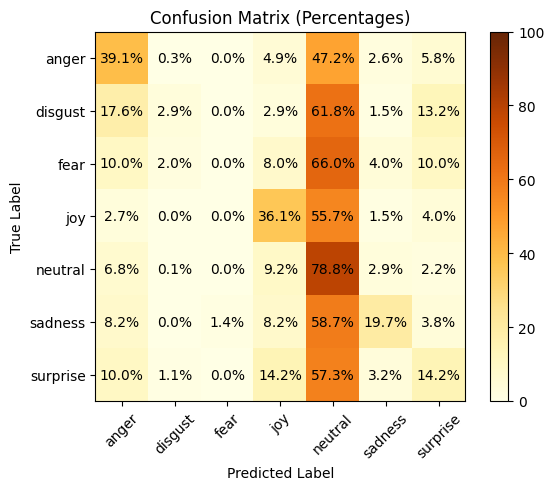


Line Conenected GCN


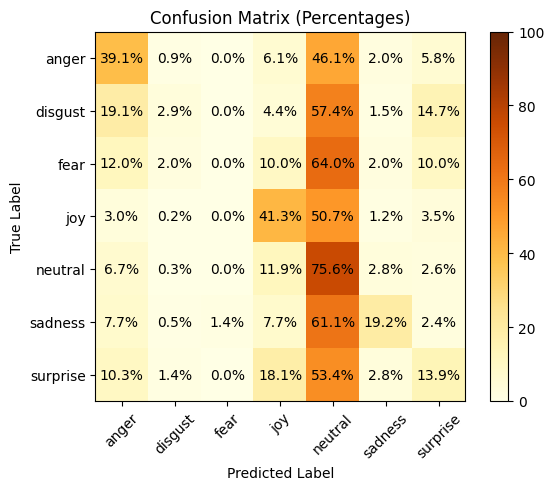


Fully Conenected GCN with sentiment shifts


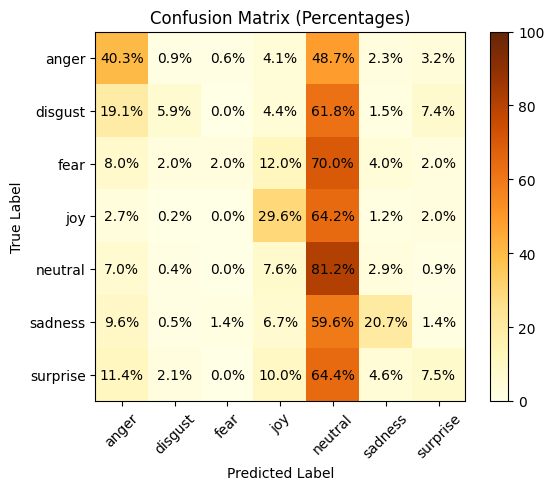


Fully Conenected GCN


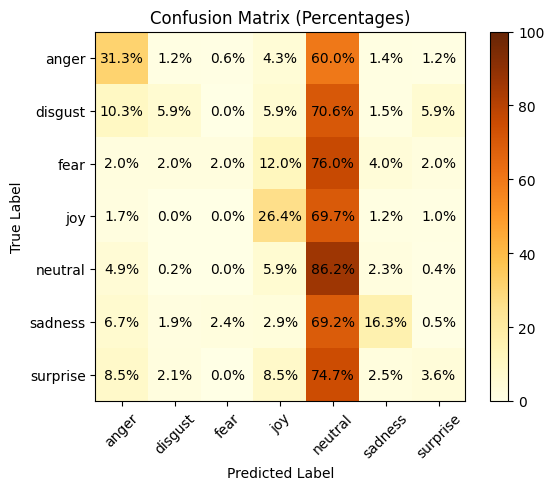


Line Conenected GAT with sentiment shifts


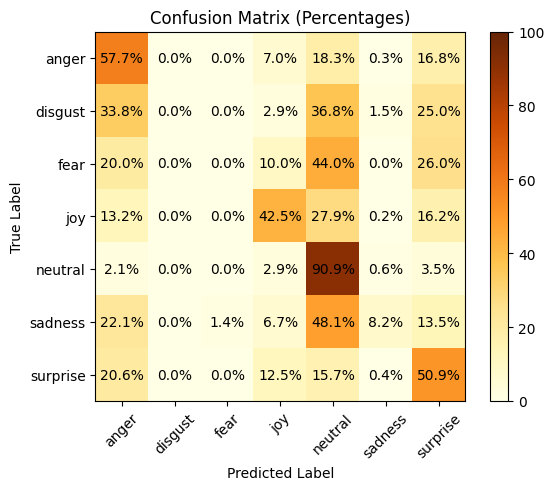


Line Conenected GAT


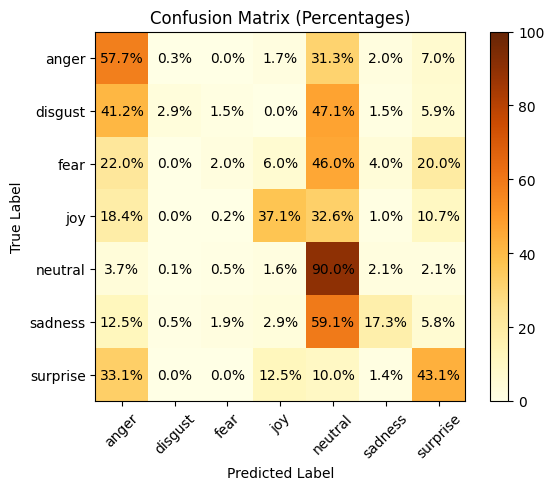


Fully Conenected GAT with sentiment shifts


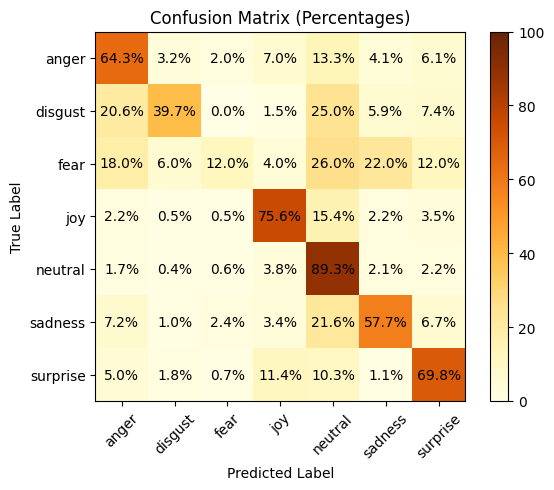


Fully Conenected GAT


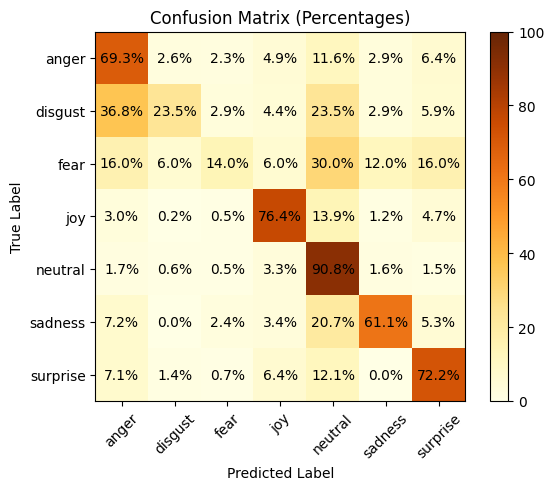

In [ ]:
models = {
    "Line Connected GCN with sentiment shifts":gcn_lcon_ss,
    "Line Connected GCN":gcn_lcon,
    "Fully Connected GCN with sentiment shifts":gcn_fcon_ss,
    "Fully Connected GCN":gcn_fcon,

    "Line Connected GAT with sentiment shifts":gat_lcon_ss,
    "Line Connected GAT":gat_lcon,
    "Fully Connected GAT with sentiment shifts":gat_fcon_ss,
    "Fully Connected GAT":gat_fcon,
}

for model_name, model in models.items():
  print(model_name)
  printF1Score(model)
  print()
print("\n\n")
for model_name, model in models.items():
  print(model_name)
  showCM(model)
  print()